# The following is redone for the GCM with the maximum number of NANS by analyzing the Bias correction Zarr

### Finding the nearest non-nan node to each transect point

1) We do this by first selecting a single timeslice to be evaluated. time step 3 is chosen. It is assumed the the nan/dry points in this timestep will have nan values in all others
2) Creating a function that for each transect point calculates the distance between the transect point and all era5 nodes 361*720
3) Then for said transect point, it seaches within a search radius usuallly ~3degrees and filters out the nan points using np.isfinite method
4) It then saves Hs the value of the closest point.
5) Difficulty arrises when we try to trace back from this 1D value to the 2D equivalent lon-lat
6) keen attention needs to be paid to the search radius, because if the distance filtered dataset is too short, it will not be able to find the hs result eg in the Northern sea of japan, arabian gulf and northern russia where there are no ERA5 values but there are transects present. If it is too big however,then you run the risk of having duplicate values.
7) In the end it was decided to use the ERA5 resulting transect --> nearest offshore node mapping results for the GCM simulations
8) Keep in mind ERA5 and the GCM has latitudes switched, so flip the  max and min latitudes when doing isel

The following notebook describes this endeavor:


In [1]:
# %pip install pystac_client==0.4
# %pip install plotly

In [2]:
import pystac_client
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from itertools import compress
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import plotly.graph_objects as go
import plotly.express as px

from tqdm import tqdm


In [3]:
ERA5_Mean=xr.open_zarr(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\01_Present\Extreme_wave_height\ERA5_Mean_1993-2014.zarr")
ERA5_Mean=ERA5_Mean.compute()
# ERA5_Mean["swh"].plot()
ERA5_Mean

<xarray.Dataset>
Dimensions:    (latitude: 361, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
Data variables:
    swh        (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan

In [4]:
Bias_correction=xr.open_zarr(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\01_Present\Extreme_wave_height\ERA5 Nearshore Mapping\STEP 3- Bias Correcting Annual Mean\Delta_Bias_correction.zarr")
Bias_correction=Bias_correction.compute()
Bias_correction

<xarray.Dataset>
Dimensions:             (latitude: 361, longitude: 720)
Coordinates:
  * latitude            (latitude) float32 -90.0 -89.5 -89.0 ... 89.0 89.5 90.0
  * longitude           (longitude) float32 0.0 0.5 1.0 ... 358.5 359.0 359.5
Data variables:
    Δ_hs_ACCESS_CM2     (latitude, longitude) float32 nan nan nan ... nan nan
    Δ_hs_AWI_CM_1_1_MR  (latitude, longitude) float32 nan nan nan ... nan nan
    Δ_hs_CMCC_CM2_SR5   (latitude, longitude) float32 nan nan nan ... nan nan
    Δ_hs_EC_EARTH3      (latitude, longitude) float32 nan nan nan ... nan nan
    Δ_hs_IPSL_CM6A_LR   (latitude, longitude) float32 nan nan nan ... nan nan
    Δ_hs_KIOST_ESM      (latitude, longitude) float32 nan nan nan ... nan nan
    Δ_hs_MPI_ESM1_2_LR  (latitude, longitude) float32 nan nan nan ... nan nan
    Δ_hs_MRI_ESM2_0     (latitude, longitude) float32 nan nan nan ... nan nan

Find the variable with the most nans

In [5]:
nan_count =np.isnan(ERA5_Mean["swh"].values).sum()
nan_count

97057

In [6]:
nan_count_all=[]
for var in list(Bias_correction.data_vars.keys()):
  nan_count =np.isnan(Bias_correction[var].values).sum()
  nan_count_all.append(nan_count)
nan_count_all

[105688, 102734, 99944, 103156, 101190, 110050, 104127, 104542]

In [7]:
max_val=np.max(nan_count_all)
max_val
max_nan=np.where(nan_count_all==max_val)
max_nan_idx=max_nan[0][0]

In [8]:
max_nan_var=list(Bias_correction.data_vars.keys())[max_nan_idx]
max_nan_var

'Δ_hs_KIOST_ESM'

In [9]:
ds=Bias_correction[max_nan_var]
ds=ds.to_dataset()
ds

<xarray.Dataset>
Dimensions:         (latitude: 361, longitude: 720)
Coordinates:
  * latitude        (latitude) float32 -90.0 -89.5 -89.0 ... 89.0 89.5 90.0
  * longitude       (longitude) float32 0.0 0.5 1.0 1.5 ... 358.5 359.0 359.5
Data variables:
    Δ_hs_KIOST_ESM  (latitude, longitude) float32 nan nan nan ... nan nan nan

Flip the latitude and variables to conform to ERA5

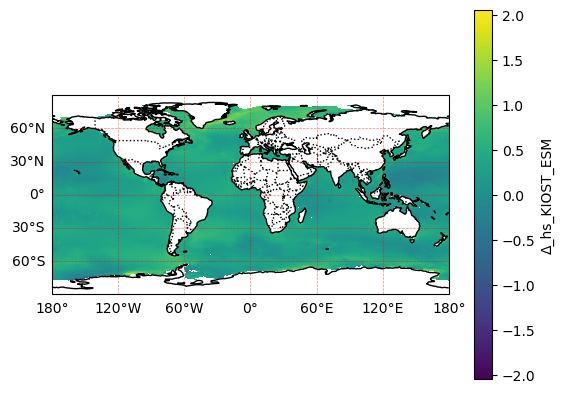

In [10]:


# Create a map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the variable
ds[max_nan_var].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')

# Add features like coastlines, borders, and ocean
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', edgecolor='black')
# ax.add_feature(cartopy.feature.OCEAN)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='red', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Set the title
# plt.title('Wave Height')

# Show the plot
plt.show()

In [11]:
#Change longitude coordinate
def longitude_coverter(lon):
    if lon <0:
        lon=lon+360
    else:
        lon=lon
    return lon

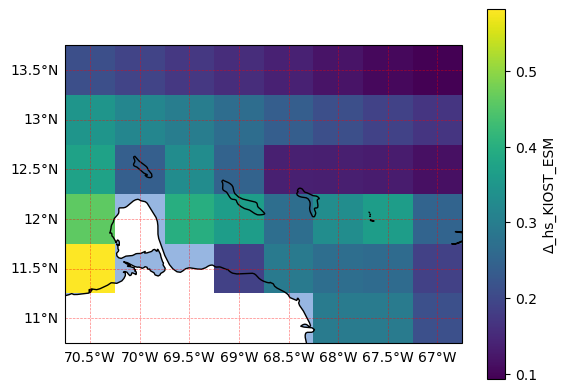

In [12]:

lon_min=-66.985558489
lon_max=-70.897144235

var=max_nan_var
time_step=0
lat_min=10.641308809
lat_max=13.734711864


# #Change longitude coordinate
# def longitude_coverter(lon_min, lon_max)
#     lon_span=[lon_min,lon_max]

#     for i,lon in enumerate(lon_span):
#         if lon <0:
#             lon_span[i]=lon+360
#         else:
#             lon_span[i]=lon
#     return lon_span

# #Change longitude coordinate
# def longitude_coverter(lon):
#         if lon <0:
#             lon=lon+360
#         else:
#             lon=lon
#         return lon

lon_span=[longitude_coverter(lon_min),longitude_coverter(lon_max)]





# Create a map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the variable
ds.sel(longitude=slice(np.min(lon_span),np.max(lon_span)),latitude=slice(lat_min,lat_max))[var].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')

# Add features like coastlines, borders, and ocean
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', edgecolor='black')
ax.add_feature(cartopy.feature.OCEAN)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='red', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Set the title
# plt.title('Wave Height')

# Show the plot
plt.show()

create a scatterplot

In [13]:
ds

<xarray.Dataset>
Dimensions:         (latitude: 361, longitude: 720)
Coordinates:
  * latitude        (latitude) float32 -90.0 -89.5 -89.0 ... 89.0 89.5 90.0
  * longitude       (longitude) float32 0.0 0.5 1.0 1.5 ... 358.5 359.0 359.5
Data variables:
    Δ_hs_KIOST_ESM  (latitude, longitude) float32 nan nan nan ... nan nan nan

In [14]:
# ds_f=ds.isel(time=3)
ds_f=ds

ds_f

<xarray.Dataset>
Dimensions:         (latitude: 361, longitude: 720)
Coordinates:
  * latitude        (latitude) float32 -90.0 -89.5 -89.0 ... 89.0 89.5 90.0
  * longitude       (longitude) float32 0.0 0.5 1.0 1.5 ... 358.5 359.0 359.5
Data variables:
    Δ_hs_KIOST_ESM  (latitude, longitude) float32 nan nan nan ... nan nan nan

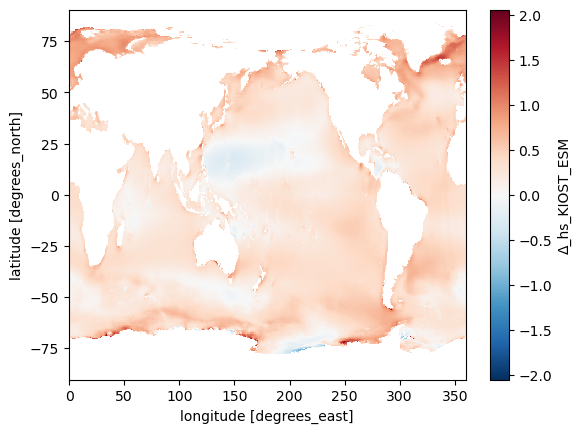

In [15]:
ds_f[var].plot()

Testing the method desctibed in the heading

In [16]:
lat=17.1423649741 #Arabian gulf example (data for ERA5 none for GCMs)
lon=42.4197296827
variable=max_nan_var

#Find the distances between the point above (sample transect point) and all 361*720 ERA5 nodes
distances = np.sqrt((ds_f.latitude - lat)**2 + (ds_f.longitude - lon)**2)

# Find valid (non-NaN) values
valid_indices = np.isfinite(ds_f[variable])

# Exclude NaN values from consideration
valid_distances = distances.values[valid_indices.values]

# Find the nearest valid point
nearest_index = np.argmin(valid_distances)

# Get the value at the nearest valid point
nearest_value = ds_f[variable].values[valid_indices][nearest_index]


#Reduce the search radius around the transect point to reduce possibility of having the same value here 10degrees are used
reduced_selection=ds_f.sel(latitude=slice(lat-10,lat+10),longitude=slice(lon-10,lon+10))

# Find indices where 'hs' values in reduced_selection are equal to nearest_value (We can stop here)
indices = np.where(reduced_selection[variable].values == nearest_value)

# Extract latitude and longitude wave height values corresponding to the indices
nearest_lat = reduced_selection.latitude.values[indices[0][0]]
nearest_lon = reduced_selection.longitude.values[indices[1][0]]
nearest_value

0.53617966

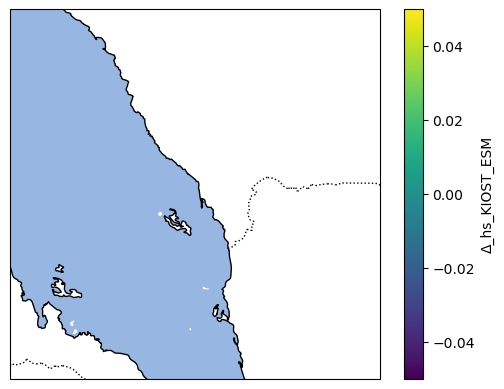

In [17]:
search_radius=3
ax = plt.axes(projection=ccrs.PlateCarree())
ds_f.sel(latitude=slice(lat-search_radius,lat+search_radius),longitude=slice(lon-search_radius,lon+search_radius))[var].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')
# Add features like coastlines, borders, and ocean
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', edgecolor='black')
ax.add_feature(cartopy.feature.OCEAN)

In [18]:
####### Create a function from the above so it can be reused in a loop
# lat=-50.5
# lon=285.5
variable=max_nan_var

def find_nearest_non_nan(ds_f, lat, lon,variable,search_radius):
    variable
    # Compute distances from the target point
    distances = np.sqrt((ds_f.latitude - lat)**2 + (ds_f.longitude - lon)**2)

    # Find valid (non-NaN) values
    valid_indices = np.isfinite(ds_f[variable])

    # Exclude NaN values from consideration
    valid_distances = distances.values[valid_indices.values]

    # Find the nearest valid point
    nearest_index = np.argmin(valid_distances)

    # Get the value at the nearest valid point
    nearest_value = ds_f[variable].values[valid_indices][nearest_index]
    nearest_value

    reduced_selection=ds_f.sel(latitude=slice(lat-search_radius,lat+search_radius),longitude=slice(lon-search_radius,lon+search_radius))

    #if there is 1 or less real value is within range the index of the nearest value is given
        
    if len(reduced_selection[variable].values[~np.isnan(reduced_selection[variable].values)])>1 :
        # Find indices where 'hs' values in reduced_selection are equal to nearest_value
        indices = np.where(reduced_selection[variable].values == nearest_value)

        # Extract latitude and longitude values corresponding to the indices
        nearest_lat = reduced_selection.latitude.values[indices[0][0]]
        nearest_lon = reduced_selection.longitude.values[indices[1][0]]
    
    if len(reduced_selection[variable].values[~np.isnan(reduced_selection[variable].values)])<=1:
        nearest_lat = ds_f.sel(latitude=lat,longitude=lon,method="nearest").latitude.values+0
        nearest_lon = ds_f.sel(latitude=lat,longitude=lon,method="nearest").longitude.values+0

    return nearest_lat, nearest_lon

In [19]:
df=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\All_Datasets\Orig_Datasets\04_Auxillary_files\Arjen_Vector_Template.csv")
df

,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat
0,BOX_028_183_0,CHL,South America,Chile,-74.386310,-50.377659,-74.390966,-50.382558,-74.395623,-50.387456
1,BOX_028_183_1,CHL,South America,Chile,-74.382469,-50.379144,-74.387125,-50.384042,-74.391782,-50.388940
2,BOX_028_183_2,CHL,South America,Chile,-74.378628,-50.380629,-74.383284,-50.385527,-74.387941,-50.390425
3,BOX_028_183_3,CHL,South America,Chile,-74.373950,-50.382583,-74.379517,-50.387079,-74.385083,-50.391574
4,BOX_028_183_4,CHL,South America,Chile,-74.370425,-50.384358,-74.375991,-50.388853,-74.381558,-50.393348
...,...,...,...,...,...,...,...,...,...,...
1739821,BOX_211_067_149,RUS,Europe,Russia,39.929937,64.701462,39.935198,64.698350,39.940460,64.695238
1739822,BOX_211_067_150,RUS,Europe,Russia,39.933577,64.702586,39.938839,64.699474,39.944100,64.696363
1739823,BOX_211_067_151,RUS,Europe,Russia,39.935546,64.703502,39.942003,64.700833,39.948460,64.698164
1739824,BOX_211_067_152,RUS,Europe,Russia,39.937050,64.704370,39.944697,64.702356,39.952343,64.700341


In [20]:
find_nearest_non_nan(ds_f, -74.390966, longitude_coverter(-50.382558),variable,search_radius)


(-74.5, 309.5)

In [21]:
df["near_lat"]=np.nan
df["near_lon"]=np.nan
df

,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,near_lat,near_lon
0,BOX_028_183_0,CHL,South America,Chile,-74.386310,-50.377659,-74.390966,-50.382558,-74.395623,-50.387456,NaN,NaN
1,BOX_028_183_1,CHL,South America,Chile,-74.382469,-50.379144,-74.387125,-50.384042,-74.391782,-50.388940,NaN,NaN
2,BOX_028_183_2,CHL,South America,Chile,-74.378628,-50.380629,-74.383284,-50.385527,-74.387941,-50.390425,NaN,NaN
3,BOX_028_183_3,CHL,South America,Chile,-74.373950,-50.382583,-74.379517,-50.387079,-74.385083,-50.391574,NaN,NaN
4,BOX_028_183_4,CHL,South America,Chile,-74.370425,-50.384358,-74.375991,-50.388853,-74.381558,-50.393348,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1739821,BOX_211_067_149,RUS,Europe,Russia,39.929937,64.701462,39.935198,64.698350,39.940460,64.695238,NaN,NaN
1739822,BOX_211_067_150,RUS,Europe,Russia,39.933577,64.702586,39.938839,64.699474,39.944100,64.696363,NaN,NaN
1739823,BOX_211_067_151,RUS,Europe,Russia,39.935546,64.703502,39.942003,64.700833,39.948460,64.698164,NaN,NaN
1739824,BOX_211_067_152,RUS,Europe,Russia,39.937050,64.704370,39.944697,64.702356,39.952343,64.700341,NaN,NaN



1) If the below loop runs smoothly then hurray!, if not that usually means the search radius was too small. 
2) you can examine and decide how to deal with these problem regions by plotting it and examining where has no data
find_nearest_non_nan(ds_f,lat,lon,variable,search_radius)
3) Solution is again to increase the search radius. this is also risky as it may cause attribute distant unrealistic waves to the shoreline transects
4) You can also just assign a nan however this has the repercussion of having large stretches of land with no data
5) The script usuallt takes 3hrs hence why it is smart do it once and save the results for the other GCM

In [22]:
variable=max_nan_var
search_radius=3
for i, (lat, lon) in tqdm(enumerate(zip(df["Intersect_lat"], df["Intersect_lon"])), desc="inserting slice", total=len(df)):
    # if lon>0:
    #     continue
    # lat=-50.5
    if np.isnan(lat) | np.isnan(lon):
        continue
    lon=longitude_coverter(lon)
    try:
        df.iloc[i, 10], df.iloc[i, 11] = find_nearest_non_nan(ds_f, lat, lon, variable, search_radius)
    except Exception as e:
        # If an exception occurs, set the values to np.nan
        df.iloc[i, 10] = np.nan
        df.iloc[i, 11] = np.nan
        print(f"Exception occurred at index {i}: {e}")
df

inserting slice:  59%|█████▉    | 1022779/1739826 [53:00<35:51, 333.28it/s] 

Exception occurred at index 1022725: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1022726: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1022727: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1022728: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1022729: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1022730: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1022731: index 0 is out of bounds for axis 0 with size 0


inserting slice:  63%|██████▎   | 1100376/1739826 [56:59<31:23, 339.54it/s]

Exception occurred at index 1100316: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100317: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100318: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100319: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100320: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100321: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100322: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100323: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100324: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100325: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100326: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100327: index 0 is out of bounds for

inserting slice:  63%|██████▎   | 1100443/1739826 [56:59<34:31, 308.65it/s]

Exception occurred at index 1100402: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100403: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100404: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100405: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100406: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100407: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100408: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100409: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100410: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100411: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100412: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100413: index 0 is out of bounds for

inserting slice:  63%|██████▎   | 1100693/1739826 [57:00<41:42, 255.44it/s]

Exception occurred at index 1100666: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100667: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100668: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1100669: index 0 is out of bounds for axis 0 with size 0


inserting slice:  64%|██████▍   | 1118598/1739826 [57:58<33:08, 312.36it/s]

Exception occurred at index 1118553: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1118554: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1118555: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1118556: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1118557: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1118558: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1118559: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1118560: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1118561: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1118562: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1118563: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1118564: index 0 is out of bounds for

inserting slice:  64%|██████▍   | 1120084/1739826 [58:03<30:10, 342.31it/s]

Exception occurred at index 1120019: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1120020: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1120021: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1120022: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1120023: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1120024: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1120025: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1120026: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1120027: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1120028: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1120029: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1120030: index 0 is out of bounds for

inserting slice:  64%|██████▍   | 1120119/1739826 [58:03<30:41, 336.60it/s]

Exception occurred at index 1120084: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1120085: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1120086: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1120087: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1120088: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1120089: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1120090: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1120091: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1120092: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1120093: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1120094: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1120095: index 0 is out of bounds for

inserting slice:  66%|██████▌   | 1140756/1739826 [59:10<30:43, 325.04it/s]

Exception occurred at index 1140721: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140722: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140723: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140724: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140725: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140726: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140727: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140728: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140729: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140730: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140731: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140732: index 0 is out of bounds for

inserting slice:  66%|██████▌   | 1140851/1739826 [59:10<34:15, 291.40it/s]

Exception occurred at index 1140810: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140811: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140812: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140813: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140814: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140815: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140816: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140817: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140818: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140819: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140820: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140821: index 0 is out of bounds for

inserting slice:  66%|██████▌   | 1140881/1739826 [59:10<44:58, 221.92it/s]

Exception occurred at index 1140867: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140868: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140869: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140870: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140871: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140872: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140873: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140874: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140875: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140876: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140877: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140878: index 0 is out of bounds for

inserting slice:  66%|██████▌   | 1140933/1739826 [59:11<44:14, 225.63it/s]

Exception occurred at index 1140889: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140890: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140891: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140892: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1140893: index 0 is out of bounds for axis 0 with size 0


inserting slice:  66%|██████▌   | 1142828/1739826 [59:17<29:12, 340.73it/s]

Exception occurred at index 1142776: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1142777: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1142778: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1142779: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1142780: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1142781: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1142782: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1142783: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1142784: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1142785: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1142786: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1142787: index 0 is out of bounds for

inserting slice:  66%|██████▌   | 1142897/1739826 [59:17<33:29, 297.01it/s]

Exception occurred at index 1142849: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1142850: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1142851: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1142852: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1142853: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1142854: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1142855: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1142856: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1142857: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1142858: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1142859: index 0 is out of bounds for axis 0 with size 0
Exception occurred at index 1142860: index 0 is out of bounds for

inserting slice: 100%|██████████| 1739826/1739826 [1:32:03<00:00, 314.96it/s]


,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,near_lat,near_lon
0,BOX_028_183_0,CHL,South America,Chile,-74.386310,-50.377659,-74.390966,-50.382558,-74.395623,-50.387456,-50.5,284.5
1,BOX_028_183_1,CHL,South America,Chile,-74.382469,-50.379144,-74.387125,-50.384042,-74.391782,-50.388940,-50.5,284.5
2,BOX_028_183_2,CHL,South America,Chile,-74.378628,-50.380629,-74.383284,-50.385527,-74.387941,-50.390425,-50.5,284.5
3,BOX_028_183_3,CHL,South America,Chile,-74.373950,-50.382583,-74.379517,-50.387079,-74.385083,-50.391574,-50.5,284.5
4,BOX_028_183_4,CHL,South America,Chile,-74.370425,-50.384358,-74.375991,-50.388853,-74.381558,-50.393348,-50.5,284.5
...,...,...,...,...,...,...,...,...,...,...,...,...
1739821,BOX_211_067_149,RUS,Europe,Russia,39.929937,64.701462,39.935198,64.698350,39.940460,64.695238,66.5,41.0
1739822,BOX_211_067_150,RUS,Europe,Russia,39.933577,64.702586,39.938839,64.699474,39.944100,64.696363,66.5,41.0
1739823,BOX_211_067_151,RUS,Europe,Russia,39.935546,64.703502,39.942003,64.700833,39.948460,64.698164,66.5,41.0
1739824,BOX_211_067_152,RUS,Europe,Russia,39.937050,64.704370,39.944697,64.702356,39.952343,64.700341,66.5,41.0


In [23]:
df.to_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\01_Present\Extreme_wave_height\ERA5 Nearshore Mapping\Step1- Node to transect\All_Transects_GCMmap.csv",index=False)

In [24]:
df=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\01_Present\Extreme_wave_height\ERA5 Nearshore Mapping\Step1- Node to transect\All_Transects_GCMmap.csv")
df

,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,near_lat,near_lon
0,BOX_028_183_0,CHL,South America,Chile,-74.386310,-50.377659,-74.390966,-50.382558,-74.395623,-50.387456,-50.5,284.5
1,BOX_028_183_1,CHL,South America,Chile,-74.382469,-50.379144,-74.387125,-50.384042,-74.391782,-50.388940,-50.5,284.5
2,BOX_028_183_2,CHL,South America,Chile,-74.378628,-50.380629,-74.383284,-50.385527,-74.387941,-50.390425,-50.5,284.5
3,BOX_028_183_3,CHL,South America,Chile,-74.373950,-50.382583,-74.379517,-50.387079,-74.385083,-50.391574,-50.5,284.5
4,BOX_028_183_4,CHL,South America,Chile,-74.370425,-50.384358,-74.375991,-50.388853,-74.381558,-50.393348,-50.5,284.5
...,...,...,...,...,...,...,...,...,...,...,...,...
1739821,BOX_211_067_149,RUS,Europe,Russia,39.929937,64.701462,39.935198,64.698350,39.940460,64.695238,66.5,41.0
1739822,BOX_211_067_150,RUS,Europe,Russia,39.933577,64.702586,39.938839,64.699474,39.944100,64.696363,66.5,41.0
1739823,BOX_211_067_151,RUS,Europe,Russia,39.935546,64.703502,39.942003,64.700833,39.948460,64.698164,66.5,41.0
1739824,BOX_211_067_152,RUS,Europe,Russia,39.937050,64.704370,39.944697,64.702356,39.952343,64.700341,66.5,41.0


In [25]:
df["Lat_Lon"]=list(zip(df["near_lat"],df["near_lon"]))
df

,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,near_lat,near_lon,Lat_Lon
0,BOX_028_183_0,CHL,South America,Chile,-74.386310,-50.377659,-74.390966,-50.382558,-74.395623,-50.387456,-50.5,284.5,"(-50.5, 284.5)"
1,BOX_028_183_1,CHL,South America,Chile,-74.382469,-50.379144,-74.387125,-50.384042,-74.391782,-50.388940,-50.5,284.5,"(-50.5, 284.5)"
2,BOX_028_183_2,CHL,South America,Chile,-74.378628,-50.380629,-74.383284,-50.385527,-74.387941,-50.390425,-50.5,284.5,"(-50.5, 284.5)"
3,BOX_028_183_3,CHL,South America,Chile,-74.373950,-50.382583,-74.379517,-50.387079,-74.385083,-50.391574,-50.5,284.5,"(-50.5, 284.5)"
4,BOX_028_183_4,CHL,South America,Chile,-74.370425,-50.384358,-74.375991,-50.388853,-74.381558,-50.393348,-50.5,284.5,"(-50.5, 284.5)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739821,BOX_211_067_149,RUS,Europe,Russia,39.929937,64.701462,39.935198,64.698350,39.940460,64.695238,66.5,41.0,"(66.5, 41.0)"
1739822,BOX_211_067_150,RUS,Europe,Russia,39.933577,64.702586,39.938839,64.699474,39.944100,64.696363,66.5,41.0,"(66.5, 41.0)"
1739823,BOX_211_067_151,RUS,Europe,Russia,39.935546,64.703502,39.942003,64.700833,39.948460,64.698164,66.5,41.0,"(66.5, 41.0)"
1739824,BOX_211_067_152,RUS,Europe,Russia,39.937050,64.704370,39.944697,64.702356,39.952343,64.700341,66.5,41.0,"(66.5, 41.0)"


In [26]:
df.to_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\01_Present\Extreme_wave_height\ERA5 Nearshore Mapping\Step1- Node to transect\All_Transects_GCMmap_2014_zip_added.csv")

In [27]:
df=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\01_Present\Extreme_wave_height\ERA5 Nearshore Mapping\Step1- Node to transect\All_Transects_GCMmap_2014_zip_added.csv")
df

,Unnamed: 0,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,near_lat,near_lon,Lat_Lon
0,0,BOX_028_183_0,CHL,South America,Chile,-74.386310,-50.377659,-74.390966,-50.382558,-74.395623,-50.387456,-50.5,284.5,"(-50.5, 284.5)"
1,1,BOX_028_183_1,CHL,South America,Chile,-74.382469,-50.379144,-74.387125,-50.384042,-74.391782,-50.388940,-50.5,284.5,"(-50.5, 284.5)"
2,2,BOX_028_183_2,CHL,South America,Chile,-74.378628,-50.380629,-74.383284,-50.385527,-74.387941,-50.390425,-50.5,284.5,"(-50.5, 284.5)"
3,3,BOX_028_183_3,CHL,South America,Chile,-74.373950,-50.382583,-74.379517,-50.387079,-74.385083,-50.391574,-50.5,284.5,"(-50.5, 284.5)"
4,4,BOX_028_183_4,CHL,South America,Chile,-74.370425,-50.384358,-74.375991,-50.388853,-74.381558,-50.393348,-50.5,284.5,"(-50.5, 284.5)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739821,1739821,BOX_211_067_149,RUS,Europe,Russia,39.929937,64.701462,39.935198,64.698350,39.940460,64.695238,66.5,41.0,"(66.5, 41.0)"
1739822,1739822,BOX_211_067_150,RUS,Europe,Russia,39.933577,64.702586,39.938839,64.699474,39.944100,64.696363,66.5,41.0,"(66.5, 41.0)"
1739823,1739823,BOX_211_067_151,RUS,Europe,Russia,39.935546,64.703502,39.942003,64.700833,39.948460,64.698164,66.5,41.0,"(66.5, 41.0)"
1739824,1739824,BOX_211_067_152,RUS,Europe,Russia,39.937050,64.704370,39.944697,64.702356,39.952343,64.700341,66.5,41.0,"(66.5, 41.0)"


In [28]:
#Find the unique values to prevent recalculations
df["Lat_Lon"]=list(zip(df["near_lat"],df["near_lon"])) #change from string to tuple due to read_csv
unique_points=df["Lat_Lon"].unique()
unique_points

array([(-50.5, 284.5), (-47.5, 285.0), (-48.5, 284.5), ..., (65.0, 37.0),
       (64.5, 36.5), (64.5, 37.5)], dtype=object)

In [29]:
len(unique_points)

5542

In [30]:
x_list=[]
y_list=[]

for x,y in tqdm(unique_points,desc="creating dataframe"):
    x_list.append(x)
    y_list.append(y)

df_unique = pd.DataFrame({
    'lat': x_list,
    'lon': y_list,
    'lat_lon': unique_points
})
df_unique

creating dataframe: 100%|██████████| 5542/5542 [00:00<00:00, 924836.19it/s]


,lat,lon,lat_lon
0,-50.5,284.5,"(-50.5, 284.5)"
1,-47.5,285.0,"(-47.5, 285.0)"
2,-48.5,284.5,"(-48.5, 284.5)"
3,-49.0,284.5,"(-49.0, 284.5)"
4,-53.5,286.0,"(-53.5, 286.0)"
...,...,...,...
5537,64.0,37.5,"(64.0, 37.5)"
5538,65.0,37.5,"(65.0, 37.5)"
5539,65.0,37.0,"(65.0, 37.0)"
5540,64.5,36.5,"(64.5, 36.5)"


## Save the unique results mapper, this can now be used for the ERA5 and GCM mappings

In [31]:
df_unique.to_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\01_Present\Extreme_wave_height\ERA5 Nearshore Mapping\Step1- Node to transect\Unique_Points_no_nan_GCM_2014.csv",index=False)

In [32]:
df_unique=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\01_Present\Extreme_wave_height\ERA5 Nearshore Mapping\Step1- Node to transect\Unique_Points_no_nan_GCM_2014.csv")
df_unique

,lat,lon,lat_lon
0,-50.5,284.5,"(-50.5, 284.5)"
1,-47.5,285.0,"(-47.5, 285.0)"
2,-48.5,284.5,"(-48.5, 284.5)"
3,-49.0,284.5,"(-49.0, 284.5)"
4,-53.5,286.0,"(-53.5, 286.0)"
...,...,...,...
5537,64.0,37.5,"(64.0, 37.5)"
5538,65.0,37.5,"(65.0, 37.5)"
5539,65.0,37.0,"(65.0, 37.0)"
5540,64.5,36.5,"(64.5, 36.5)"


In [33]:
import plotly.express as px


# Plotting using Plotly Express with Mapbox
fig = px.scatter_mapbox(df_unique, 
                        lat='lat', 
                        lon='lon', 
                        hover_data=['lat_lon'],
                        mapbox_style="carto-positron")
fig.show()

### To observe how the previous method using the built in nearest function from xr.sel(blah, method="nearest") gives values inland

In [34]:

df_unique_old=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\01_Present\Extreme_wave_height\ERA5 Nearshore Mapping\Step1- Node to transect\Unique_Points_before_nan_removal algorithm.csv")
df_unique_old

,lat,lon,lat_lon
0,-50.5,285.5,"(-50.5, 285.5)"
1,-50.5,286.0,"(-50.5, 286.0)"
2,-47.5,285.0,"(-47.5, 285.0)"
3,-48.5,284.5,"(-48.5, 284.5)"
4,-49.0,284.5,"(-49.0, 284.5)"
...,...,...,...
8253,65.0,37.0,"(65.0, 37.0)"
8254,65.5,40.0,"(65.5, 40.0)"
8255,64.5,36.5,"(64.5, 36.5)"
8256,64.5,40.5,"(64.5, 40.5)"


In [35]:
# Filter for inland points ie the differences and plot them as red
df_nan = df_unique_old[~df_unique_old['lat_lon'].isin(df_unique['lat_lon'])].copy()
df_nan

,lat,lon,lat_lon
0,-50.5,285.5,"(-50.5, 285.5)"
1,-50.5,286.0,"(-50.5, 286.0)"
5,-53.5,286.5,"(-53.5, 286.5)"
6,-52.5,288.0,"(-52.5, 288.0)"
7,-53.0,287.5,"(-53.0, 287.5)"
...,...,...,...
8248,64.5,39.5,"(64.5, 39.5)"
8249,65.5,39.5,"(65.5, 39.5)"
8250,64.5,39.0,"(64.5, 39.0)"
8254,65.5,40.0,"(65.5, 40.0)"


In [36]:
import plotly.express as px



# Plotting using Plotly Express with Mapbox
fig = px.scatter_mapbox(df_nan, 
                        lat='lat', 
                        lon='lon',
                        color_discrete_sequence=['red'],# Set all markers to red 
                        hover_data=['lat_lon'],
                        mapbox_style="carto-positron",
                        title="Locations with NaN values")
# Adding trace for unique values
fig.add_trace(px.scatter_mapbox(df_unique, 
                                lat='lat', 
                                lon='lon', 
                                color_discrete_sequence=['blue'],# Set all markers to blue
                                hover_data=['lat_lon'],
                                mapbox_style="carto-positron",
                                title="Unique Locations").data[0])

fig.show()


In [37]:
df_unique

,lat,lon,lat_lon
0,-50.5,284.5,"(-50.5, 284.5)"
1,-47.5,285.0,"(-47.5, 285.0)"
2,-48.5,284.5,"(-48.5, 284.5)"
3,-49.0,284.5,"(-49.0, 284.5)"
4,-53.5,286.0,"(-53.5, 286.0)"
...,...,...,...
5537,64.0,37.5,"(64.0, 37.5)"
5538,65.0,37.5,"(65.0, 37.5)"
5539,65.0,37.0,"(65.0, 37.0)"
5540,64.5,36.5,"(64.5, 36.5)"
